# Using xarray to solve Heterogeneous Agent Models


Import required libraries.


In [1]:
from types import SimpleNamespace

import estimagic as em
import numpy as np
import xarray as xr
from xarray import DataArray, Dataset

from HARK.ConsumptionSaving.ConsIndShockModel import PerfForesightConsumerType
from HARK.rewards import UtilityFuncCRRA
from HARK.utilities import plot_funcs

Here are some basic parameters that we'll use to construct the model. `CRRA` is the coefficient of constant relative risk aversion, `DiscFac` is the intertemporal discount factor, and `Rfree` is the interest rate on savings.


In [2]:
epsilon = 1e-6  # lower bound for cash-on-hand
CRRA = 2.0  # coefficient of relative risk aversion
DiscFac = 0.96  # discounting factor
Rfree = 1.03  # risk free interest rate
params = SimpleNamespace(CRRA=CRRA, DiscFac=DiscFac, Rfree=Rfree)


util = UtilityFuncCRRA(CRRA)

### The Problem


First, we explore the structure of a perfect-foresight consumption-savings model. The agent's problem is to maximize their present discounted utility of consumption subject to a budget constraint. The recursive problem is given by

$$
v_t(m_t) = \max_{c_t} u(c_t) + \beta v_{t+1}(m_{t+1}) \\
s.t. \\
 a_t = m_t - c_t \\
m_{t+1} = R  a_t + 1
$$


This problem can be disected into two stages and two transitions:

First, the agent chooses consumption $c_t$ to maximize their utility given their current cash-on-hand $m_t$ and is left with liquid assets $a_t$. This problem must obey their budget constraint, such that assets is equal to cash-on-hand minus consumption.

$$
v_t(m_t) = \max_{c_t} u(c_t) + \beta w_{t}(a_{t}) \\
s.t. \\
 a_t = m_t - c_t \\
$$

Second, the agent receives a constant income and the liquid assets accrue interest, which results in next period's cash-on-hand $m_{t+1}$.

$$
w_t(a_t) = v_{t+1}(m_{t+1}) \\
s.t. \\
 m_{t+1} = R  a_t + 1
$$

Although this is very simple, it will be apparent later why this separation is useful.


### Defining the state space.


We can define the state space two ways: as a numpy grid, or as an xarray.DataArrray.


In [3]:
mVec = np.geomspace(epsilon, 20, 100)  # grid for market resources

The xr.DataArray will be useful for representing the state space in a more general way. We can define the state space as a 1-dimensional array of cash-on-hand values. For our simple example, we use a 1 variable xr.Dataset to represent the state space.


In [4]:
mNrm = DataArray(
    mVec,
    name="mNrm",
    dims=("mNrm"),
    attrs={"long_name": "Normalized Market Resources"},
)
state = Dataset({"mNrm": mNrm})  # only one state var in this model

Notice the structure of an xr.Dataset which includes `mNrm` as a dimension.


In [5]:
state

<xarray.Dataset> Size: 800B
Dimensions:  (mNrm: 100)
Coordinates:
  * mNrm     (mNrm) float64 800B 1e-06 1.185e-06 1.404e-06 ... 14.24 16.88 20.0
Data variables:
    *empty*

We can do the same for the liquid assets, which we can refer to as the post-decision state (post-state for short) of the first stage of the problem, or the state of the second stage of the problem.


In [6]:
aNrm = DataArray(
    mVec,
    name="aNrm",
    dims=("aNrm"),
    attrs={"long_name": "Normalized Liquid Assets"},
)
post_state = Dataset({"aNrm": aNrm})

print(post_state)

<xarray.Dataset> Size: 800B
Dimensions:  (aNrm: 100)
Coordinates:
  * aNrm     (aNrm) float64 800B 1e-06 1.185e-06 1.404e-06 ... 14.24 16.88 20.0
Data variables:
    *empty*


We can now define functions over the state space. In this basic model, we need an action/policy/decision to represent consumption. Starting from the last period, we know that the solution is for the agent to consume all of its resources `mNrm`, which induces a linear function. Defining it as a function of the state space is easy, notice in the expression below that the dimension for `cNrm` is `mNrm`.


In [7]:
# optimal decision is to consume everything in the last period
cNrm = DataArray(
    mVec,
    name="cNrm",
    dims=state.dims,
    coords=state.coords,
    attrs={"long_name": "Consumption"},
)
actions = Dataset({"cNrm": cNrm})
cNrm

<xarray.DataArray 'cNrm' (mNrm: 100)> Size: 800B
array([1.00000000e-06, 1.18508030e-06, 1.40441531e-06, 1.66434491e-06,
       1.97238237e-06, 2.33743148e-06, 2.77004399e-06, 3.28272456e-06,
       3.89029220e-06, 4.61030863e-06, 5.46358592e-06, 6.47478803e-06,
       7.67314372e-06, 9.09329144e-06, 1.07762805e-05, 1.27707577e-05,
       1.51343734e-05, 1.79354477e-05, 2.12549457e-05, 2.51888173e-05,
       2.98507711e-05, 3.53755607e-05, 4.19228800e-05, 4.96819791e-05,
       5.88771346e-05, 6.97741321e-05, 8.26879492e-05, 9.79918595e-05,
       1.16128222e-04, 1.37621268e-04, 1.63092253e-04, 1.93277416e-04,
       2.29049257e-04, 2.71441762e-04, 3.21680284e-04, 3.81216966e-04,
       4.51772715e-04, 5.35386944e-04, 6.34476519e-04, 7.51905621e-04,
       8.91068537e-04, 1.05598777e-03, 1.25143030e-03, 1.48304539e-03,
       1.75752787e-03, 2.08281165e-03, 2.46829905e-03, 2.92513257e-03,
       3.46651698e-03, 4.10810097e-03, 4.86842952e-03, 5.76947990e-03,
       6.83729695e-03, 8.10274590e-03, 9.60240452e-03, 1.13796204e-02,
       1.34857639e-02, 1.59817131e-02, 1.89396133e-02, 2.24449626e-02,
       2.65990830e-02, 3.15220491e-02, 3.73561594e-02, 4.42700484e-02,
       5.24635622e-02, 6.21735338e-02, 7.36806300e-02, 8.73174629e-02,
       1.03478205e-01, 1.22629982e-01, 1.45326375e-01, 1.72223424e-01,
       2.04098586e-01, 2.41873213e-01, 2.86639180e-01, 3.39690444e-01,
       4.02560453e-01, 4.77066461e-01, 5.65362063e-01, 6.69999442e-01,
       7.94003138e-01, 9.40957475e-01, 1.11511016e+00, 1.32149508e+00,
       1.56607779e+00, 1.85592793e+00, 2.19942362e+00, 2.60649360e+00,
       3.08890421e+00, 3.66059952e+00, 4.33810437e+00, 5.14100201e+00,
       6.09250019e+00, 7.22010194e+00, 8.55640055e+00, 1.01400217e+01,
       1.20167399e+01, 1.42408017e+01, 1.68764936e+01, 2.00000000e+01])
Coordinates:
  * mNrm     (mNrm) float64 800B 1e-06 1.185e-06 1.404e-06 ... 14.24 16.88 20.0
Attributes:
    long_name:  Consumption

### The Value and Marginal Value functions.


To define the value and marginal value functions in the last period, we can use the utility and marginal utility functions.


In [8]:
v = util(cNrm)
v.name = "v"
v.attrs = {"long_name": "Value Function"}

v_der = util.der(cNrm)
v_der.name = "v_der"
v_der.attrs = {"long_name": "Marginal Value Function"}

It will also be useful to define the inverse value and inverse marginal value functions.


In [9]:
v_inv = cNrm.copy()
v_inv.name = "v_inv"
v_inv.attrs = {"long_name": "Inverse Value Function"}

v_der_inv = cNrm.copy()
v_der_inv.name = "v_der_inv"
v_der_inv.attrs = {"long_name": "Inverse Marginal Value Function"}

We can now create a xr.Dataset to store all of the variables/functions we have created. Datasets are useful containers of variables that are defined over the same dimensions, or in our case states. As we can see, every variable in the dataset shares the same dimension of `mNrm`.


In [10]:
dataset = Dataset(
    {
        "cNrm": cNrm,
        "v": v,
        "v_der": v_der,
        "v_inv": v_inv,
        "v_der_inv": v_der_inv,
    },
)
dataset

<xarray.Dataset> Size: 5kB
Dimensions:    (mNrm: 100)
Coordinates:
  * mNrm       (mNrm) float64 800B 1e-06 1.185e-06 1.404e-06 ... 16.88 20.0
Data variables:
    cNrm       (mNrm) float64 800B 1e-06 1.185e-06 1.404e-06 ... 16.88 20.0
    v          (mNrm) float64 800B -1e+06 -8.438e+05 ... -0.05925 -0.05
    v_der      (mNrm) float64 800B 1e+12 7.12e+11 5.07e+11 ... 0.003511 0.0025
    v_inv      (mNrm) float64 800B 1e-06 1.185e-06 1.404e-06 ... 16.88 20.0
    v_der_inv  (mNrm) float64 800B 1e-06 1.185e-06 1.404e-06 ... 16.88 20.0

We can also create separate datasets for the value function variables and the policy function variable.


In [11]:
value_function = Dataset(
    {"v": v, "v_der": v_der, "v_inv": v_inv, "v_der_inv": v_der_inv},
)
policy_function = Dataset({"cNrm": cNrm})

Up to now I've used the word function for the variables stored as datasets. This is because using the `interp` method we can interpolate the values of the variables at any point in the state space. So, if we have enough points we can approximate the true functions numerically. This is useful for solving the model, as we will see later.


In [12]:
dataset.interp({"mNrm": np.sort(np.random.uniform(epsilon, 20, 10))})

<xarray.Dataset> Size: 480B
Dimensions:    (mNrm: 10)
Coordinates:
  * mNrm       (mNrm) float64 80B 1.085 1.486 3.464 6.606 ... 12.76 15.49 18.98
Data variables:
    cNrm       (mNrm) float64 80B 1.085 1.486 3.464 6.606 ... 12.76 15.49 18.98
    v          (mNrm) float64 80B -0.9257 -0.6775 -0.2905 ... -0.065 -0.05302
    v_der      (mNrm) float64 80B 0.8609 0.462 0.08498 ... 0.004255 0.00283
    v_inv      (mNrm) float64 80B 1.085 1.486 3.464 6.606 ... 12.76 15.49 18.98
    v_der_inv  (mNrm) float64 80B 1.085 1.486 3.464 6.606 ... 12.76 15.49 18.98

Because of the curvature of the value and marginal value functions, it'll be useful to use the inverse value and marginal value functions instead and re-curve them. For this, I create a new class `ValueFunctionCRRA` that returns the appropriate value and marginal value functions.


In [13]:
class ValueFunctionCRRA:
    def __init__(self, dataset: xr.Dataset, CRRA: float):
        self.dataset = dataset
        self.CRRA = CRRA
        self.u = UtilityFuncCRRA(CRRA)

    def __call__(self, state):
        """Interpolate inverse falue function then invert to get value function at given state."""
        result = self.u(
            self.dataset["v_inv"].interp(
                state,
                assume_sorted=True,
                kwargs={"fill_value": "extrapolate"},
            ),
        )

        result.name = "v"
        result.attrs = self.dataset["v"].attrs

        return result

    def derivative(self, state):
        """Interpolate inverse marginal value function then invert to get marginal value function at given state."""
        result = self.u.der(
            self.dataset["v_der_inv"].interp(
                state,
                assume_sorted=True,
                kwargs={"fill_value": "extrapolate"},
            ),
        )

        result.name = "v_der"
        result.attrs = self.dataset["v"].attrs

        return result

    def evaluate(self, state):
        """Interpolate all data variables in the dataset."""
        result = self.dataset.interp(state, kwargs={"fill_value": "extrapolate"})
        result.attrs = self.dataset["v"].attrs

        return result

Now we can create a `ValueFuncCRRA` that will appropriately recurve the value and marginal value functions.

In [14]:
vfunc = ValueFunctionCRRA(value_function, CRRA)

For an example of how this is useful, we can create a random grid of states and compare the differences in the 2 approaches.

In [15]:
rand_states = np.sort(np.random.uniform(mVec[1], mVec[-1], 100))
rand_states

array([9.43425735e-04, 5.30976251e-01, 7.14360739e-01, 1.10045416e+00,
       1.40722838e+00, 1.42674492e+00, 1.84004637e+00, 2.33185956e+00,
       2.36897788e+00, 2.47353532e+00, 2.64965534e+00, 2.65432103e+00,
       2.70285132e+00, 2.85032835e+00, 3.07108234e+00, 3.36852058e+00,
       3.51388131e+00, 4.84009415e+00, 4.99158166e+00, 5.59497122e+00,
       5.71063997e+00, 5.73534554e+00, 5.80039518e+00, 5.88846528e+00,
       5.90523924e+00, 5.94363698e+00, 5.97584879e+00, 6.19555735e+00,
       6.38151926e+00, 6.59898452e+00, 6.64389407e+00, 7.06031363e+00,
       7.28541060e+00, 7.85966957e+00, 8.06134906e+00, 8.06190103e+00,
       8.32329135e+00, 8.72350895e+00, 8.86150815e+00, 9.19066246e+00,
       9.27468004e+00, 9.53258557e+00, 9.54377466e+00, 9.74971407e+00,
       9.80025793e+00, 1.03679374e+01, 1.06617927e+01, 1.09027355e+01,
       1.10261685e+01, 1.11254188e+01, 1.11439399e+01, 1.12308237e+01,
       1.12697534e+01, 1.14202268e+01, 1.16489826e+01, 1.17534881e+01,
      

If we simply linearly interpolate the value and marginal value functions using `xarray` interpolation, we get the following results.

In [16]:
rand_ds = vfunc.evaluate({"mNrm": rand_states})
rand_ds

<xarray.Dataset> Size: 4kB
Dimensions:    (mNrm: 100)
Coordinates:
  * mNrm       (mNrm) float64 800B 0.0009434 0.531 0.7144 ... 19.62 19.82 19.84
Data variables:
    v          (mNrm) float64 800B -1.067e+03 -1.896 ... -0.05053 -0.05048
    v_der      (mNrm) float64 800B 1.144e+06 3.621 1.998 ... 0.002558 0.002553
    v_inv      (mNrm) float64 800B 0.0009434 0.531 0.7144 ... 19.62 19.82 19.84
    v_der_inv  (mNrm) float64 800B 0.0009434 0.531 0.7144 ... 19.62 19.82 19.84
Attributes:
    long_name:  Value Function

However, if we use the inverse value and marginal value functions to interpolate and then re-curve, the results are slightly different.

In [17]:
rand_v = vfunc({"mNrm": rand_states})
np.max(np.abs(rand_v - rand_ds["v"]))

<xarray.DataArray 'v' ()> Size: 8B
array(6.63881557)

The correct answer is of course, the re-curving one using `ValueFunctionCRRA`, as evidenced by the following check. As a reminder, the value function at this stage is the utility of consumption, which in the last period is the utility of the cash-on-hand.

In [18]:
rand_v - util(rand_states)

<xarray.DataArray 'v' (mNrm: 100)> Size: 800B
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Coordinates:
  * mNrm     (mNrm) float64 800B 0.0009434 0.531 0.7144 ... 19.62 19.82 19.84

### Transitions

Another useful feature of `xarray` is that we can easily define the state transitions. Using labels, we can define expresive equations that are easy to read and understand.


In [19]:
def state_transition(state=None, action=None, params=None):
    """State to post_state transition"""
    post_state = {}  # pytree
    post_state["aNrm"] = state["mNrm"] - action["cNrm"]
    return post_state


def post_state_transition(post_state=None, params=None):
    """post_state to next_state transition"""
    next_state = {}  # pytree
    next_state["mNrm"] = params.Rfree * post_state["aNrm"] + 1
    return next_state

This makes it very easy to define simulations of the model given initial states and optimal actions.

In [20]:
Dataset(state_transition(state, policy_function, params))

<xarray.Dataset> Size: 2kB
Dimensions:  (mNrm: 100)
Coordinates:
  * mNrm     (mNrm) float64 800B 1e-06 1.185e-06 1.404e-06 ... 14.24 16.88 20.0
Data variables:
    aNrm     (mNrm) float64 800B 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

In [21]:
Dataset(post_state_transition(post_state, params))

<xarray.Dataset> Size: 2kB
Dimensions:  (aNrm: 100)
Coordinates:
  * aNrm     (aNrm) float64 800B 1e-06 1.185e-06 1.404e-06 ... 14.24 16.88 20.0
Data variables:
    mNrm     (aNrm) float64 800B 1.0 1.0 1.0 1.0 1.0 ... 13.38 15.67 18.38 21.6

These transitions can also be composed.

In [22]:
Dataset(post_state_transition(state_transition(state, dataset, params), params))

<xarray.Dataset> Size: 800B
Dimensions:  (mNrm: 100)
Coordinates:
  * mNrm     (mNrm) float64 800B 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
Data variables:
    *empty*

We can even define more complex transitions where several variables are created along the way. In the example below, we define the value of an action given some initial state and continuation function, which is the value of having taken that action.

The continuation value function is then the value of some initial post-decision state, which is the value of having taken that action and ending up with next period's state.

In [23]:
def value_transition(action=None, state=None, continuation=None, params=None):
    """Value of action given state and continuation"""
    variables = {}  # pytree
    post_state = state_transition(state, action, params)
    variables.update(post_state)

    variables["reward"] = util(action["cNrm"])
    variables["v"] = variables["reward"] + params.DiscFac * continuation(post_state)
    variables["v_inv"] = util.inv(variables["v"])

    variables["marginal_reward"] = util.der(action["cNrm"])
    variables["v_der"] = variables["marginal_reward"]  # envelope condition
    variables["v_der_inv"] = util.derinv(variables["v_der"])

    # for estimagic purposes
    variables["contributions"] = variables["v_inv"]
    variables["value"] = np.sum(variables["v_inv"])

    return variables


def continuation_transition(post_state=None, value_next=None, params=None):
    """Continuation value function of post_states"""
    variables = {}  # pytree
    next_state = post_state_transition(post_state, params)
    variables.update(next_state)

    variables["v"] = value_next(next_state)
    variables["v_inv"] = util.inv(variables["v"])

    variables["v_der"] = params.Rfree * value_next.derivative(next_state)
    variables["v_der_inv"] = util.derinv(variables["v_der"])

    # for estimagic purposes
    variables["contributions"] = variables["v_inv"]
    variables["value"] = np.sum(variables["v_inv"])

    return variables

From these transitions, we can easily calculate the continuation value function as follows.

In [24]:
v_end = Dataset(continuation_transition(post_state, vfunc, params))
v_end = v_end.drop(["mNrm"])  # next period's mNrm is not needed
v_end

/tmp/ipykernel_176111/2779588421.py:2: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  v_end = v_end.drop(["mNrm"])  # next period's mNrm is not needed


<xarray.Dataset> Size: 5kB
Dimensions:        (aNrm: 100)
Coordinates:
  * aNrm           (aNrm) float64 800B 1e-06 1.185e-06 1.404e-06 ... 16.88 20.0
Data variables:
    v              (aNrm) float64 800B -1.0 -1.0 -1.0 ... -0.0544 -0.0463
    v_inv          (aNrm) float64 800B 1.0 1.0 1.0 1.0 ... 15.67 18.38 21.6
    v_der          (aNrm) float64 800B 1.03 1.03 1.03 ... 0.003048 0.002208
    v_der_inv      (aNrm) float64 800B 0.9853 0.9853 0.9853 ... 18.11 21.28
    contributions  (aNrm) float64 800B 1.0 1.0 1.0 1.0 ... 15.67 18.38 21.6
    value          float64 8B 231.9

In [25]:
wfunc = ValueFunctionCRRA(v_end, CRRA)

For an example, we can calculate the value of taking the same action as in the last period in the second to last period. As a reminder, that action is consuming everything and saving 0.

In [26]:
Dataset(value_transition(policy_function, state, wfunc, params))

<xarray.Dataset> Size: 7kB
Dimensions:          (mNrm: 100)
Coordinates:
  * mNrm             (mNrm) float64 800B 1e-06 1.185e-06 ... 16.88 20.0
    aNrm             (mNrm) float64 800B 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Data variables:
    reward           (mNrm) float64 800B -1e+06 -8.438e+05 ... -0.05925 -0.05
    v                (mNrm) float64 800B -1e+06 -8.438e+05 ... -1.019 -1.01
    v_inv            (mNrm) float64 800B 1e-06 1.185e-06 ... 0.9811 0.9901
    marginal_reward  (mNrm) float64 800B 1e+12 7.12e+11 ... 0.003511 0.0025
    v_der            (mNrm) float64 800B 1e+12 7.12e+11 ... 0.003511 0.0025
    v_der_inv        (mNrm) float64 800B 1e-06 1.185e-06 ... 16.88 20.0
    contributions    (mNrm) float64 800B 1e-06 1.185e-06 ... 0.9811 0.9901
    value            float64 8B 18.93

## Solving the Model

It should be obvious however, that this is not the optimal action. The optimal action will consist of consuming some of the resources and saving the rest, but how much exactly to save is not straightforward. For this, we can use numerical optimizer `estimagic` to find the optimal action.

In [27]:
res = em.maximize(
    value_transition,
    params={"cNrm": mVec / 2},
    algorithm="scipy_lbfgsb",
    criterion_kwargs={"state": state, "continuation": wfunc, "params": params},
    lower_bounds={"cNrm": np.zeros_like(mVec)},
    upper_bounds={"cNrm": state["mNrm"].data},
)

c_opt = DataArray(
    res.params["cNrm"],
    name="cNrm",
    dims=state.dims,
    coords=state.coords,
    attrs={"long_name": "consumption"},
)
optimal_actions = Dataset({"cNrm": c_opt})
optimal_value = Dataset(value_transition(optimal_actions, state, wfunc, params))
grid_search = xr.merge([optimal_actions, optimal_value])
grid_search

<xarray.Dataset> Size: 8kB
Dimensions:          (mNrm: 100)
Coordinates:
  * mNrm             (mNrm) float64 800B 1e-06 1.185e-06 ... 16.88 20.0
    aNrm             (mNrm) float64 800B 0.0 0.0 0.0 0.0 ... 6.501 7.795 9.33
Data variables:
    cNrm             (mNrm) float64 800B 1e-06 1.185e-06 ... 9.081 10.67
    reward           (mNrm) float64 800B -1e+06 -8.438e+05 ... -0.1101 -0.09372
    v                (mNrm) float64 800B -1e+06 -8.438e+05 ... -0.2164 -0.1842
    v_inv            (mNrm) float64 800B 1e-06 1.185e-06 ... 4.62 5.429
    marginal_reward  (mNrm) float64 800B 1e+12 7.12e+11 ... 0.01213 0.008784
    v_der            (mNrm) float64 800B 1e+12 7.12e+11 ... 0.01213 0.008784
    v_der_inv        (mNrm) float64 800B 1e-06 1.185e-06 ... 9.081 10.67
    contributions    (mNrm) float64 800B 1e-06 1.185e-06 ... 4.62 5.429
    value            float64 8B 40.31

As we can see by looking at the `value` variable, the optimization (grid search) method provides a higher value than the naive strategy of consuming everything. We can also easily plot what this maximization looks like.

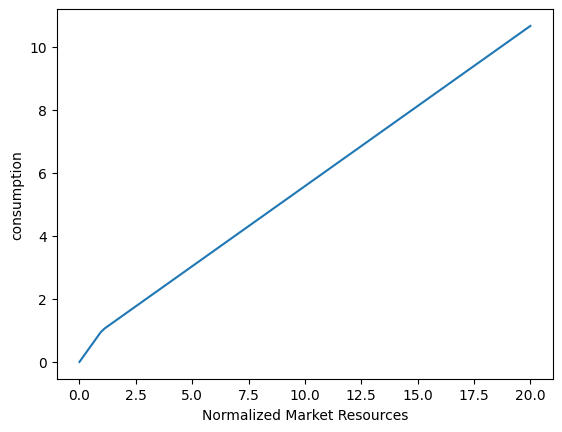

In [28]:
grid_search["cNrm"].plot()

For comparison, we can also check these results against `HARK`'s traditional model solution.

In [29]:
hark_agent = PerfForesightConsumerType(
    CRRA=params.CRRA,
    DiscFac=params.DiscFac,
    Rfree=params.Rfree,
    LivPrb=[1.0],
    PermGroFac=[1.0],
    BoroCnstArt=0.0,
)
hark_agent.solve()

np.max(np.abs(hark_agent.solution[0].cFunc(mVec) - grid_search["cNrm"]))

<xarray.DataArray 'cNrm' ()> Size: 8B
array(0.00036464)

## Endogenous Grid Method

As we can see above, the differences are very small. This is because `HARK` uses the endogenous grid method instead of a grid search method to find an optimal solution. To see the endogenous grid method in action, we can instead do the following.

The endogenous grid method consists of starting from the post-decision state and deriving the optimal action that rationalizes ending up at that state.

To do this, the endogenous grid method uses the first order condition of the problem, as can be seen in the `egm_transition` function. Having obtained the optimal consumption from a given post-decision state, we can now back out the starting cash-on-hand that would have induced that consumption.



In [30]:
def reverse_transition(post_state=None, action=None, params=None):
    states = {}  # pytree
    states["mNrm"] = post_state["aNrm"] + action["cNrm"]

    return states


def egm_transition(post_state=None, continuation=None, params=None):
    """Actions from post_states"""
    actions = {}  # pytree
    actions["cNrm"] = util.derinv(params.DiscFac * continuation.derivative(post_state))

    return actions

In [31]:
acted = egm_transition(post_state, wfunc, params)
states = reverse_transition(post_state, acted, params)

actions = Dataset(acted).swap_dims({"aNrm": "mNrm"})  # egm requires swap dimensions
states = Dataset(states).swap_dims({"aNrm": "mNrm"})

egm_dataset = xr.merge([actions, states])

values = value_transition(actions, states, wfunc, params)
egm_dataset.update(values)

<xarray.Dataset> Size: 8kB
Dimensions:          (mNrm: 100)
Coordinates:
    aNrm             (mNrm) float64 800B 1e-06 1.185e-06 ... 16.88 20.0
  * mNrm             (mNrm) float64 800B 1.006 1.006 1.006 ... 30.0 35.36 41.72
Data variables:
    cNrm             (mNrm) float64 800B 1.006 1.006 1.006 ... 15.76 18.49 21.72
    reward           (mNrm) float64 800B -0.9944 -0.9944 ... -0.05409 -0.04604
    v                (mNrm) float64 800B -1.954 -1.954 ... -0.1063 -0.09048
    v_inv            (mNrm) float64 800B 0.5117 0.5117 0.5117 ... 9.406 11.05
    marginal_reward  (mNrm) float64 800B 0.9888 0.9888 ... 0.002926 0.002119
    v_der            (mNrm) float64 800B 0.9888 0.9888 ... 0.002926 0.002119
    v_der_inv        (mNrm) float64 800B 1.006 1.006 1.006 ... 15.76 18.49 21.72
    contributions    (mNrm) float64 800B 0.5117 0.5117 0.5117 ... 9.406 11.05
    value            float64 8B 118.7

Because we have imposed an artificial borrowing constraint of 0, we can not optimize our problem at `aNrm` = 0 using the first order condition. Instead, we have to plug in these values.

In [32]:
borocnst = Dataset(
    coords={
        "mNrm": 0.0,
        "aNrm": 0.0,
    },
    data_vars={
        "cNrm": 0.0,
        "v": -np.inf,
        "v_inv": 0.0,
        "reward": -np.inf,
        "marginal_reward": np.inf,
        "v_der": np.inf,
        "v_der_inv": 0.0,
    },
)

egm = xr.concat([borocnst, egm_dataset], dim="mNrm", combine_attrs="no_conflicts")
egm

<xarray.Dataset> Size: 9kB
Dimensions:          (mNrm: 101)
Coordinates:
  * mNrm             (mNrm) float64 808B 0.0 1.006 1.006 ... 30.0 35.36 41.72
    aNrm             (mNrm) float64 808B 0.0 1e-06 1.185e-06 ... 16.88 20.0
Data variables:
    cNrm             (mNrm) float64 808B 0.0 1.006 1.006 ... 15.76 18.49 21.72
    v                (mNrm) float64 808B -inf -1.954 -1.954 ... -0.1063 -0.09048
    v_inv            (mNrm) float64 808B 0.0 0.5117 0.5117 ... 8.017 9.406 11.05
    reward           (mNrm) float64 808B -inf -0.9944 ... -0.05409 -0.04604
    marginal_reward  (mNrm) float64 808B inf 0.9888 0.9888 ... 0.002926 0.002119
    v_der            (mNrm) float64 808B inf 0.9888 0.9888 ... 0.002926 0.002119
    v_der_inv        (mNrm) float64 808B 0.0 1.006 1.006 ... 15.76 18.49 21.72
    contributions    (mNrm) float64 808B nan 0.5117 0.5117 ... 8.017 9.406 11.05
    value            (mNrm) float64 808B nan 118.7 118.7 ... 118.7 118.7 118.7

Now, we can compare the endogenous grid method approach with `HARK`'s solution, and see that the difference is now much smaller and numerically trivial.

In [33]:
np.max(np.abs(egm["cNrm"].interp({"mNrm": mVec}) - hark_agent.solution[0].cFunc(mVec)))

<xarray.DataArray 'cNrm' ()> Size: 8B
array(9.35671381e-07)

## `ConsLabeledModels`

The `ConsLabeledModels` module provides a number of models that are defined using the `xarray` framework. Below we show some simple examples of how to use these models.

### PerfForesightLabeledType

The `PerfForesightLabeledType` is a perfect foresight model with a constant interest rate and a constant income, so the agent experiences no uncertainty.

In [34]:
from HARK.ConsumptionSaving.ConsLabeledModel import (
    PerfForesightLabeledType,
)

agent = PerfForesightLabeledType(cycles=0, BoroCnstArt=-1.0)
agent.solve()

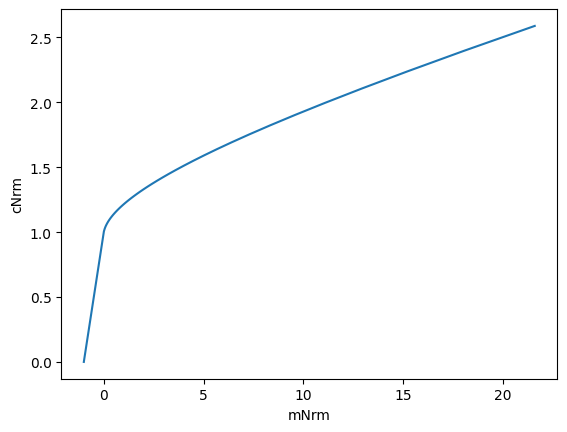

In [35]:
agent.solution[0].policy["cNrm"].plot()

The model is equivalent to `PerfForesightConsumerType` presented below.

In [36]:
hark_agent = PerfForesightConsumerType(cycles=0, BoroCnstArt=-1.0)
hark_agent.solve()

/mnt/c/Users/alujan/GitHub/alanlujan91/HARK/HARK/metric.py:52: UserWarning: Arrays of different shapes. Returning differences in size.
  warn("Arrays of different shapes. Returning differences in size.")


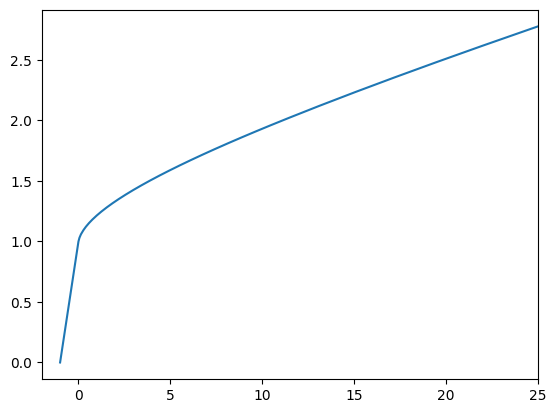

In [37]:
plot_funcs(hark_agent.solution[0].cFunc, hark_agent.solution[0].mNrmMin - 1, 25)

The difference in the two models is small.

In [38]:
np.max(
    np.abs(
        hark_agent.solution[0].cFunc(mVec)
        - agent.solution[0].policy["cNrm"].interp({"mNrm": mVec}),
    ),
)

<xarray.DataArray 'cNrm' ()> Size: 8B
array(0.00671175)

### `IndShockLabeledType`

The `IndShockLabeledType` is a model with idiosyncratic shocks to income. The model is equivalent to `IndShockConsumerType` presented below.

In [39]:
from HARK.ConsumptionSaving.ConsLabeledModel import IndShockLabeledType

agent = IndShockLabeledType(cycles=0)
agent.solve()

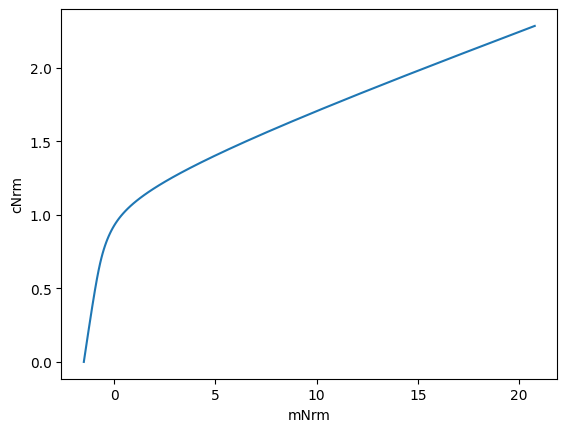

In [40]:
agent.solution[0].policy["cNrm"].plot()

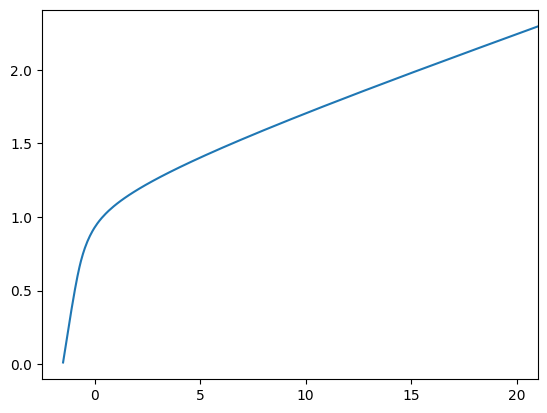

In [41]:
from HARK.ConsumptionSaving.ConsIndShockModel import IndShockConsumerType

hark_agent = IndShockConsumerType(cycles=0, BoroCnstArt=None)
hark_agent.solve()

plot_funcs(hark_agent.solution[0].cFunc, hark_agent.solution[0].mNrmMin - 1, 21)

The difference in the two models is small.

In [42]:
mgrid = np.linspace(hark_agent.solution[0].mNrmMin, 20)
np.max(
    np.abs(
        hark_agent.solution[0].cFunc(mgrid)
        - agent.solution[0].policy["cNrm"].interp({"mNrm": mgrid}),
    ),
)

<xarray.DataArray 'cNrm' ()> Size: 8B
array(0.00023666)

### RiskyAssetLabeled Type

The `RiskyAssetLabeledType` is a model with idiosyncratic shocks to income and a risky asset. The model is equivalent to `RiskyAssetConsumerType`.

In [43]:
from HARK.ConsumptionSaving.ConsLabeledModel import RiskyAssetLabeledType

agent = RiskyAssetLabeledType(cycles=0)
agent.solve()

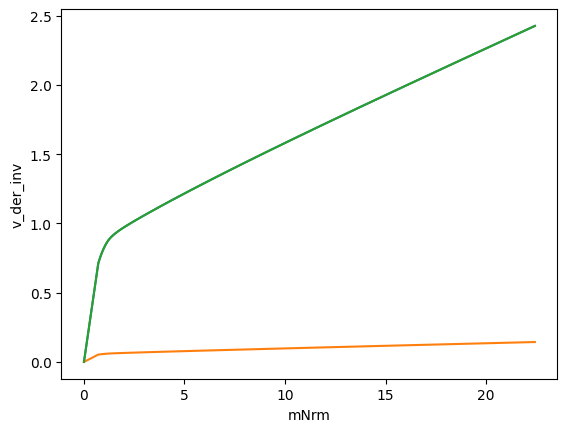

In [44]:
agent.solution[0].policy["cNrm"].plot()
agent.solution[0].value.dataset["v_inv"].plot()
agent.solution[0].value.dataset["v_der_inv"].plot()

### PortfolioLabeledType

The `PortfolioLabeledType` is a model with idiosyncratic shocks to income and a risky asset and a portfolio choice. The model is equivalent to `PortfolioConsumerType`. First we see the consumption function.

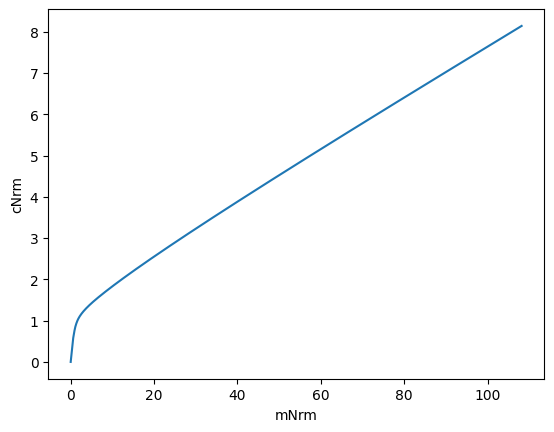

In [45]:
from HARK.ConsumptionSaving.ConsLabeledModel import PortfolioLabeledType

agent = PortfolioLabeledType(cycles=0)
agent.solve()
agent.solution[0].policy["cNrm"].plot()

Now we can plot the optimal risky share of portfolio conditional on the initial state of market resources.

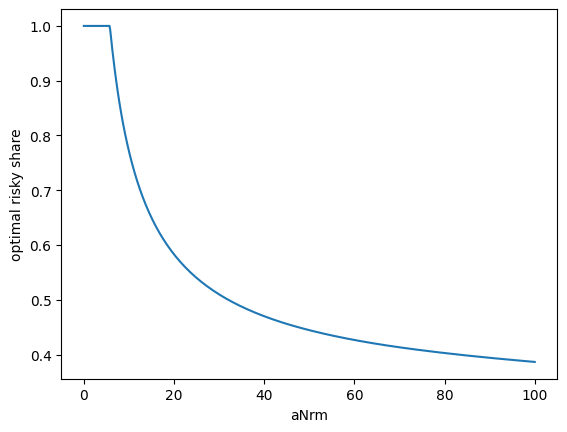

In [46]:
agent.solution[0].continuation.dataset["stigma"].plot()